# SETUP

In [1]:
from functools import reduce
import os
import re

import numpy as np
import pandas as pd

import torch

In [2]:
ROOT_PATH = os.path.dirname(os.path.dirname(os.getcwd()))
DATA_PATH = os.path.join(ROOT_PATH, 'data')
MIRNA_DATA_PATH = os.path.join(DATA_PATH, 'mirna.tsv')
MIRNA_MODEL_NAME = "mirna"
MIRNA_MODEL_VERSION = "0"
MIRNA_MODEL_CHECKPOINT = "checkpoint-1000"
MIRNA_MODEL_ROOT = os.path.join(os.getcwd(), f"model={MIRNA_MODEL_NAME}", f"version={MIRNA_MODEL_VERSION}")

In [3]:
os.makedirs(MIRNA_MODEL_ROOT, exist_ok=True)

In [4]:
MIRNA_DATA_PATH, MIRNA_MODEL_ROOT

('/mnt/data/home/dkarpeyev/micron/data/mirna.tsv',
 '/mnt/data/home/dkarpeyev/micron/notebooks/mirna/model=mirna/version=0')

# DATA

In [5]:
mirna_str = open(MIRNA_DATA_PATH).read().strip()

In [6]:
mirna_list = re.split(' |\n', mirna_str)

In [7]:
len(mirna_list)

5751

In [8]:
mirna_list[:9]

['a-let-7a-1',
 'MI0000060',
 'UGGGAUGAGGUAGUAGGUUGUAUAGUUUUAGGGUCACACCCACCACUGGGAGAUAACUAUACAAUCUACUGUCUUUCCUA',
 '>hsa-let-7a-2',
 'MI0000061',
 'AGGUUGAGGUAGUAGGUUGUAUAGUUUAGAAUUACAUCAAGGGAGAUAACUGUACAGCCUCCUAGCUUUCCU',
 '>hsa-let-7a-3',
 'MI0000062',
 'GGGUGAGGUAGUAGGUUGUAUAGUUUGGGGCUCUGCCCUGCUAUGGGAUAACUAUACAAUCUACUGUCUUUCCU']

In [9]:
mirna_list[-9:]

['>hsa-mir-12135',
 'MI0039739',
 'UGUGGAUAUUCUUUUUUGAUACUACAGCAAAACUCAGCAAGUUGUAGUUUUUUAAAGGUUUGUUUGUAAA',
 '>hsa-mir-12136',
 'MI0039740',
 'GAAAAAGUCAUGGAGGCCAUGGGGUUGGCUUGAAACCAGCUUUGGGGGGUUCGAUUCCUUCCUUUUUUGUC',
 '>hsa-mir-9902-2',
 'MI0041071',
 'GCAGGGAAAGGGAACCCAGAAAUCUGGUAUGCCAGCAAAGAGAGUAAGAACUUCUGACAAGCCAGGCUUCUGGUCUCUCUCUCUCUGUCUCUC']

In [10]:
mirna_array_1 = np.array(mirna_list)

In [11]:
mirna_array_1.shape

(5751,)

In [12]:
mirna_array_2 = mirna_array_1.reshape(-1,3)

In [13]:
ma = pd.DataFrame.from_records(mirna_array_2, columns=['ID', 'Accession', 'sequence'])

In [14]:
ma['ID'] = ma['ID'].map(lambda _: _[1:] if _.startswith('>') else _)

In [15]:
ma

,ID,Accession,sequence
0,a-let-7a-1,MI0000060,UGGGAUGAGGUAGUAGGUUGUAUAGUUUUAGGGUCACACCCACCAC...
1,hsa-let-7a-2,MI0000061,AGGUUGAGGUAGUAGGUUGUAUAGUUUAGAAUUACAUCAAGGGAGA...
2,hsa-let-7a-3,MI0000062,GGGUGAGGUAGUAGGUUGUAUAGUUUGGGGCUCUGCCCUGCUAUGG...
3,hsa-let-7b,MI0000063,CGGGGUGAGGUAGUAGGUUGUGUGGUUUCAGGGCAGUGAUGUUGCC...
4,hsa-let-7c,MI0000064,GCAUCCGGGUUGAGGUAGUAGGUUGUAUGGUUUAGAGUUACACCCU...
...,...,...,...
1912,hsa-mir-12132,MI0039734,UUAACAUCUUUUCCAUCAUAAUUCUCAUAGUAAUAAUAGUAAUGUU...
1913,hsa-mir-12133,MI0039735,GAAGUGUACUUUUUAAUGGUGCCAAACAGCAGUUGAUCUAUAAUAA...
1914,hsa-mir-12135,MI0039739,UGUGGAUAUUCUUUUUUGAUACUACAGCAAAACUCAGCAAGUUGUA...
1915,hsa-mir-12136,MI0039740,GAAAAAGUCAUGGAGGCCAUGGGGUUGGCUUGAAACCAGCUUUGGG...


In [16]:
reduce(lambda a, b: a.union(set(b)), ma.sequence, set())

{'A', 'C', 'G', 'U'}

In [17]:
set(ma.iloc[0].sequence)

{'A', 'C', 'G', 'U'}

## Dataset

In [18]:
DATASET_TRAIN_FRACTION = 9/10

In [19]:
import pyarrow as pa
import pyarrow.parquet as pq

In [20]:
from datasets import Dataset, DatasetDict, load_dataset, splits

In [21]:
#Dataset.from_generator?
mirna_train_dataset = Dataset.from_pandas(ma.iloc[:int(DATASET_TRAIN_FRACTION*len(ma))], split='train')
mirna_test_dataset = Dataset.from_pandas(ma.iloc[int(DATASET_TRAIN_FRACTION*len(ma)):], split='test')

In [22]:
isinstance(mirna_train_dataset.data.table, pa.Table)

True

In [23]:
MIRNA_TRAIN_PATH = os.path.join(MIRNA_MODEL_ROOT, f"{MIRNA_MODEL_NAME}_train.parquet")
pq.write_table(mirna_train_dataset.data.table, MIRNA_TRAIN_PATH)

In [24]:
MIRNA_TEST_PATH = os.path.join(MIRNA_MODEL_ROOT, f"{MIRNA_MODEL_NAME}_test.parquet")
pq.write_table(mirna_test_dataset.data.table, MIRNA_TEST_PATH)

In [25]:
mirna_datasets = DatasetDict(
    {
        "train": mirna_train_dataset,  # .shuffle().select(range(50000)),
        "test": mirna_test_dataset,  # .shuffle().select(range(500))
    }
)

In [26]:
_sequence0 = ma.iloc[0].sequence

In [27]:
MIRNA_MAX_SEQUENCE_LENGTH = max(max(len(tt) for tt in ds['sequence']) for ds in mirna_datasets.values())
MIRNA_MAX_SEQUENCE_LENGTH

180

# TOKENIZER

Building following tutorial: https://huggingface.co/course/chapter6/8?fw=pt

Specifically, 'GPT-2' BPE-based Tokenizer.

In [28]:
from functools import reduce
def get_tokenizer_training_corpus(dataset_dict, *, chunk_size):
    dd = dataset_dict
    sequence_list = reduce(lambda sequence, ds: sequence+ds['sequence'], dd.values(), [])
    for i in range(0, len(sequence_list), chunk_size):
        yield sequence_list[i:i+chunk_size]

In [29]:
from tokenizers import (
    decoders,
    models,
    normalizers,
    pre_tokenizers,
    processors,
    trainers,
    Tokenizer,
)

In [30]:
_tokenizer = Tokenizer(models.BPE()) # all tokens are known

In [31]:
_tokenizer.pre_tokenizer = pre_tokenizers.ByteLevel(add_prefix_space=False)

In [32]:
_tokenizer.pre_tokenizer.pre_tokenize_str(_sequence0)

[('UGGGAUGAGGUAGUAGGUUGUAUAGUUUUAGGGUCACACCCACCACUGGGAGAUAACUAUACAAUCUACUGUCUUUCCUA',
  (0, 80))]

In [33]:
TOKENIZER_TRAINER_CHUNK_SIZE = 200
VOCAB_SIZE = 100

In [34]:
tokenizer_trainer = trainers.BpeTrainer(vocab_size=VOCAB_SIZE, special_tokens=["<|endoftext|>"])

In [35]:
_tokenizer.train_from_iterator(get_tokenizer_training_corpus(mirna_datasets, chunk_size=TOKENIZER_TRAINER_CHUNK_SIZE), 
                              trainer=tokenizer_trainer)

In [36]:
len(_tokenizer.get_vocab())

100

In [37]:
_encoding = _tokenizer.encode(_sequence0)
_tokens = _encoding.tokens

In [38]:
print(_tokens)

['UGGG', 'AUG', 'AGG', 'UAG', 'UAGG', 'UUG', 'UA', 'UAG', 'UUUU', 'AGGG', 'UCAC', 'ACCC', 'ACC', 'AC', 'UGGG', 'AGA', 'UAAC', 'UA', 'UAC', 'AA', 'UC', 'UAC', 'UGUC', 'UU', 'UCC', 'UA']


In [39]:
_tokenizer.post_processor = processors.ByteLevel(trim_offsets=False)

In [40]:
encoding_ = _tokenizer.encode(_sequence0)
start, end = encoding_.offsets[4]
_sequence0[start:end]

'UAGG'

In [41]:
_tokenizer.decoder = decoders.ByteLevel()

In [42]:
sequence0_ = _tokenizer.decode(_encoding.ids)

In [43]:
_sequence0 == sequence0_

True

In [44]:
TOKENIZER_PATH = os.path.join(MIRNA_MODEL_ROOT, f"{MIRNA_MODEL_NAME}_tokenizer.json")

In [45]:
_tokenizer.save(TOKENIZER_PATH)

In [46]:
_tokenizer = Tokenizer.from_file(TOKENIZER_PATH)

In [47]:
from transformers import PreTrainedTokenizerFast

tokenizer = PreTrainedTokenizerFast(
    tokenizer_object=_tokenizer,
    bos_token="<|endoftext|>",
    eos_token="<|endoftext|>",
)

In [48]:
encoding = tokenizer.encode(_sequence0)

In [49]:
encoding

[22,
 29,
 14,
 30,
 59,
 20,
 17,
 30,
 40,
 25,
 50,
 56,
 26,
 12,
 22,
 27,
 73,
 17,
 28,
 9,
 11,
 28,
 64,
 8,
 16,
 17]

In [50]:
tokenizer.decode(encoding)

'UGGGAUGAGGUAGUAGGUUGUAUAGUUUUAGGGUCACACCCACCACUGGGAGAUAACUAUACAAUCUACUGUCUUUCCUA'

In [51]:
len(tokenizer)

100

In [52]:
len(tokenizer(mirna_datasets['train']['sequence'])['input_ids'])

1725

## Tokenize datasets

In [53]:
MIRNA_MAX_SEQUENCE_LENGTH

180

In [54]:
MIRNA_CONTEXT_LENGTH = None

In [55]:
mirna_datasets

DatasetDict({
    train: Dataset({
        features: ['ID', 'Accession', 'sequence'],
        num_rows: 1725
    })
    test: Dataset({
        features: ['ID', 'Accession', 'sequence'],
        num_rows: 192
    })
})

In [56]:
def tokenize(row, *, context_length=MIRNA_CONTEXT_LENGTH):
    outputs = tokenizer(
        row["sequence"],
        truncation=True,
        max_length=context_length,
        return_overflowing_tokens=True,
        return_length=True,
    )
    return outputs
    """
    input_batch = []
    for length, input_ids in zip(outputs["length"], outputs["input_ids"]):
        if length == context_length:
            input_batch.append(input_ids)
    return {"input_ids": input_batch}
    """


mirna_tokenized_datasets = mirna_datasets.map(tokenize, batched=True, remove_columns=mirna_datasets["train"].column_names)
mirna_tokenized_datasets

  0%|          | 0/2 [00:00<?, ?ba/s]

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


  0%|          | 0/1 [00:00<?, ?ba/s]

DatasetDict({
    train: Dataset({
        features: ['input_ids', 'token_type_ids', 'attention_mask', 'length', 'overflow_to_sample_mapping'],
        num_rows: 1725
    })
    test: Dataset({
        features: ['input_ids', 'token_type_ids', 'attention_mask', 'length', 'overflow_to_sample_mapping'],
        num_rows: 192
    })
})

# MODEL

In [57]:
from transformers import AutoTokenizer, GPT2LMHeadModel, AutoConfig

config = AutoConfig.from_pretrained(
    "gpt2",
    vocab_size=len(tokenizer),
    n_ctx=MIRNA_CONTEXT_LENGTH,
    bos_token_id=tokenizer.bos_token_id,
    eos_token_id=tokenizer.eos_token_id,
)

In [58]:
model = GPT2LMHeadModel(config)
model_size = sum(t.numel() for t in model.parameters())
print(f"GPT-2 size: {model_size/1000**2:.1f}M parameters")

GPT-2 size: 85.9M parameters


In [59]:
from transformers import DataCollatorForLanguageModeling

tokenizer.pad_token = tokenizer.eos_token
data_collator = DataCollatorForLanguageModeling(tokenizer, mlm=False)

Let’s have a look at an example:

In [60]:
out = data_collator([mirna_tokenized_datasets["train"][i] for i in range(5)])
for key in out:
    print(f"{key} shape: {out[key].shape}")

You're using a PreTrainedTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


input_ids shape: torch.Size([5, 30])
token_type_ids shape: torch.Size([5, 30])
attention_mask shape: torch.Size([5, 30])
length shape: torch.Size([5])
overflow_to_sample_mapping shape: torch.Size([5])
labels shape: torch.Size([5, 30])


## Train

In [61]:
GPU = 3
# Set up CUDA environment BEFORE importing torch
import os
os.environ["WANDB_DISABLED"] = "TRUE"
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = f"{GPU}"  # This shrinks the GPU universe and maps cuda:0 to {GPU}

In [62]:
import torch
torch.cuda.device_count()

1

In [63]:
torch.cuda.current_device() # This really is device {GPU}

0

In [64]:
from transformers import Trainer, TrainingArguments
import datetime
date = datetime.datetime.now().strftime('%Y-%m-%d')
time = datetime.datetime.now().strftime('%H.%M')

"""
training_args = TrainingArguments(
    output_dir=MIRNA_MODEL_ROOT,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    evaluation_strategy="steps",
    eval_steps=5_000,
    logging_steps=5_000,
    gradient_accumulation_steps=8,
    num_train_epochs=1,
    weight_decay=0.1,
    warmup_steps=1_000,
    lr_scheduler_type="cosine",
    learning_rate=5e-4,
    save_steps=5_000,
    #fp16=True,
    push_to_hub=False,
)
"""

training_args = TrainingArguments(
    output_dir=f"{MIRNA_MODEL_ROOT}",
    evaluation_strategy="epoch",
    learning_rate=2e-5,
    weight_decay=0.01,
    #place_model_on_device=torch.device(f"cuda:{GPU}"),
    push_to_hub=False,
    num_train_epochs=12.0,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
)

trainer = Trainer(
    model=model,
    tokenizer=tokenizer,
    args=training_args,
    data_collator=data_collator,
    train_dataset=mirna_tokenized_datasets["train"],
    eval_dataset=mirna_tokenized_datasets["test"],
)

Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


In [65]:
trainer.train()

The following columns in the training set don't have a corresponding argument in `GPT2LMHeadModel.forward` and have been ignored: length, overflow_to_sample_mapping. If length, overflow_to_sample_mapping are not expected by `GPT2LMHeadModel.forward`,  you can safely ignore this message.
/home/dkarpeyev/.conda/envs/py38/lib/python3.8/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 1725
  Num Epochs = 12
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 16
  Gradient Accumulation steps = 1
  Total optimization steps = 1296
  Number of trainable parameters = 85919232


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Epoch,Training Loss,Validation Loss
1,No log,4.132821
2,No log,3.974031
3,No log,3.941169
4,No log,3.915771
5,3.960500,3.918980
6,3.960500,3.908008
7,3.960500,3.914678
8,3.960500,3.908233
9,3.960500,3.916514
10,3.591300,3.940829


The following columns in the evaluation set don't have a corresponding argument in `GPT2LMHeadModel.forward` and have been ignored: length, overflow_to_sample_mapping. If length, overflow_to_sample_mapping are not expected by `GPT2LMHeadModel.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 192
  Batch size = 16
The following columns in the evaluation set don't have a corresponding argument in `GPT2LMHeadModel.forward` and have been ignored: length, overflow_to_sample_mapping. If length, overflow_to_sample_mapping are not expected by `GPT2LMHeadModel.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 192
  Batch size = 16
The following columns in the evaluation set don't have a corresponding argument in `GPT2LMHeadModel.forward` and have been ignored: length, overflow_to_sample_mapping. If length, overflow_to_sample_mapping are not expected by `GPT2LMHeadModel.forward`,  you can safely ignore this

TrainOutput(global_step=1296, training_loss=3.6866623207374856, metrics={'train_runtime': 59.5424, 'train_samples_per_second': 347.651, 'train_steps_per_second': 21.766, 'total_flos': 433596265344000.0, 'train_loss': 3.6866623207374856, 'epoch': 12.0})

In [66]:
try:
    model = model.from_pretrained(MIRNA_MODEL_ROOT)
except:
    model.to(f"cuda:0")
    trainer.train()
    model.to("cpu").save_pretrained(MIRNA_MODEL_ROOT, from_pt=True)
model.to("cuda:0")

loading configuration file /mnt/data/home/dkarpeyev/micron/notebooks/mirna/model=mirna/version=0/config.json
Model config GPT2Config {
  "_name_or_path": "/mnt/data/home/dkarpeyev/micron/notebooks/mirna/model=mirna/version=0",
  "activation_function": "gelu_new",
  "architectures": [
    "GPT2LMHeadModel"
  ],
  "attn_pdrop": 0.1,
  "bos_token_id": 0,
  "embd_pdrop": 0.1,
  "eos_token_id": 0,
  "initializer_range": 0.02,
  "layer_norm_epsilon": 1e-05,
  "model_type": "gpt2",
  "n_ctx": null,
  "n_embd": 768,
  "n_head": 12,
  "n_inner": null,
  "n_layer": 12,
  "n_positions": 1024,
  "reorder_and_upcast_attn": false,
  "resid_pdrop": 0.1,
  "scale_attn_by_inverse_layer_idx": false,
  "scale_attn_weights": true,
  "summary_activation": null,
  "summary_first_dropout": 0.1,
  "summary_proj_to_labels": true,
  "summary_type": "cls_index",
  "summary_use_proj": true,
  "task_specific_params": {
    "text-generation": {
      "do_sample": true,
      "max_length": 50
    }
  },
  "torch_dty

GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(100, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0): GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D()
          (c_proj): Conv1D()
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
      (1): GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropo

### Quick check

In [67]:
%%time
from transformers import pipeline, set_seed
generator = pipeline('text-generation', model=model, tokenizer=tokenizer)
set_seed(42)
generator("", max_length=30, num_return_sequences=5)

Generate config GenerationConfig {
  "bos_token_id": 0,
  "do_sample": true,
  "eos_token_id": 0,
  "max_length": 50,
  "transformers_version": "4.26.0"
}

/home/dkarpeyev/.conda/envs/py38/lib/python3.8/site-packages/transformers/generation/utils.py:1186: UserWarning: You have modified the pretrained model configuration to control generation. This is a deprecated strategy to control generation and will be removed soon, in a future version. Please use a generation configuration file (see https://huggingface.co/docs/transformers/main_classes/text_generation)
  warnings.warn(
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


CPU times: user 634 ms, sys: 69.2 ms, total: 703 ms
Wall time: 722 ms


[{'generated_text': 'UCAGCAGGCAGCCUUCAGAGGGAAGCACUGGGGGUUUUCCUCUGGGGAAAGGAGGCUCAUAGCGGCAGGUCCAGGGCUGGUUGGCGGC'},
 {'generated_text': 'UGCUCGGUUUGAUUCCAUCUCAAUGGUCUCAAUUAAGGCACACAGAGGGAAGCCACAAUAACAGGAAAACUAGAUGCCUACC'},
 {'generated_text': 'UGAAGCUCCUGGAUUCCCUACAAAGCAACGUACUCGGGAGAAUUGUCCGGGGCAGGUGAAAAGAAAAGGCGGGGGGGAGG'},
 {'generated_text': 'AUGUUGGCCUAGAGCAAGAAAUAUUGGCAUCUAAGAAGAUCUAAAAACAGAGAACAUCUAUUACUUUGGUAUUUGAGAUAC'},
 {'generated_text': 'UCGGG'}]

In [68]:
%%time
from transformers import pipeline, set_seed
generator = pipeline('text-generation', model=model, tokenizer=tokenizer)
set_seed(42)
generator("", max_length=30, num_return_sequences=5)

Generate config GenerationConfig {
  "bos_token_id": 0,
  "do_sample": true,
  "eos_token_id": 0,
  "max_length": 50,
  "transformers_version": "4.26.0"
}

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


CPU times: user 244 ms, sys: 1.06 ms, total: 245 ms
Wall time: 244 ms


[{'generated_text': 'UCAGCAGGCAGCCUUCAGAGGGAAGCACUGGGGGUUUUCCUCUGGGGAAAGGAGGCUCAUAGCGGCAGGUCCAGGGCUGGUUGGCGGC'},
 {'generated_text': 'UGCUCGGUUUGAUUCCAUCUCAAUGGUCUCAAUUAAGGCACACAGAGGGAAGCCACAAUAACAGGAAAACUAGAUGCCUACC'},
 {'generated_text': 'UGAAGCUCCUGGAUUCCCUACAAAGCAACGUACUCGGGAGAAUUGUCCGGGGCAGGUGAAAAGAAAAGGCGGGGGGGAGG'},
 {'generated_text': 'AUGUUGGCCUAGAGCAAGAAAUAUUGGCAUCUAAGAAGAUCUAAAAACAGAGAACAUCUAUUACUUUGGUAUUUGAGAUAC'},
 {'generated_text': 'UCGGG'}]

# LATENT-SPACE

From `transformers.generation.utils.GenerationMixin.compute_transition_scores()` docstring:


"""

...

Examples:

        ```python
        >>> from transformers import GPT2Tokenizer, AutoModelForCausalLM
        >>> import numpy as np

        >>> tokenizer = GPT2Tokenizer.from_pretrained("gpt2")
        >>> model = AutoModelForCausalLM.from_pretrained("gpt2")
        >>> tokenizer.pad_token_id = tokenizer.eos_token_id
        >>> inputs = tokenizer(["Today is"], return_tensors="pt")

        >>> # Example 1: Print the scores for each token generated with Greedy Search
        >>> outputs = model.generate(**inputs, max_new_tokens=5, return_dict_in_generate=True, output_scores=True)
        >>> transition_scores = model.compute_transition_scores(
        ...     outputs.sequences, outputs.scores, normalize_logits=True
        ... )
        >>> input_length = inputs.input_ids.shape[1]
        >>> generated_tokens = outputs.sequences[:, input_length:]
        >>> for tok, score in zip(generated_tokens[0], transition_scores[0]):
        ...     # | token | token string | logits | probability
        ...     print(f"| {tok:5d} | {tokenizer.decode(tok):8s} | {score.numpy():.3f} | {np.exp(score.numpy()):.2%}")
        |   262 |  the     | -1.414 | 24.33%
        |  1110 |  day     | -2.609 | 7.36%
        |   618 |  when    | -2.010 | 13.40%
        |   356 |  we      | -1.859 | 15.58%
        |   460 |  can     | -2.508 | 8.14%

        >>> # Example 2: Reconstruct the sequence scores from Beam Search
        >>> outputs = model.generate(
        ...     **inputs,
        ...     max_new_tokens=5,
        ...     num_beams=4,
        ...     num_return_sequences=4,
        ...     return_dict_in_generate=True,
        ...     output_scores=True,
        ... )
        >>> transition_scores = model.compute_transition_scores(
        ...     outputs.sequences, outputs.scores, outputs.beam_indices, normalize_logits=False
        ... )
        >>> # If you sum the generated tokens' scores and apply the length penalty, you'll get the sequence scores.
        >>> # Tip: set `normalize_logits=True` to recompute the scores from the normalized logits.
        >>> output_length = inputs.input_ids.shape[1] + np.sum(transition_scores.numpy() < 0, axis=1)
        >>> length_penalty = model.generation_config.length_penalty
        >>> reconstructed_scores = transition_scores.sum(axis=1) / (output_length**length_penalty)
        >>> print(np.allclose(outputs.sequences_scores, reconstructed_scores))
        True
        ```
"""
        

`generator("", max_length=30, num_return_sequences=5)` results in this call to `GenerationMixin.generate()`:

`model.generate(input_ids=None, attention_mask=None, generate_kwargs={'max_length': 30, 'num_return_sequences': 5})`

We augment it as follows:

In [67]:
NUM_RETURN_SEQUENCES = 100
MAX_LENGTH = MIRNA_MAX_SEQUENCE_LENGTH
torch.manual_seed(0);

In [68]:
%%time
outputs = model.generate(input_ids=None, 
                         attention_mask=None, 
                         return_dict_in_generate=True, 
                         output_scores=True,        # to compute perplexity/cross-entropy later
                         output_attentions=True,    # for viz
                         output_hidden_states=True, # for UMAP
                         max_length=MAX_LENGTH, 
                         num_return_sequences=NUM_RETURN_SEQUENCES)

Generate config GenerationConfig {
  "bos_token_id": 0,
  "do_sample": true,
  "eos_token_id": 0,
  "max_length": 50,
  "transformers_version": "4.26.0"
}

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


CPU times: user 3.23 s, sys: 659 ms, total: 3.89 s
Wall time: 4.23 s


## SEQUENCES (HEAD)

In [69]:
N_SAMPLES = 5
tokenizer.batch_decode(outputs.sequences[:N_SAMPLES,:], skip_special_tokens=True)

['UACUUGUCCGAGCACUGGACGCUUAGCCUUCUGCUUUCCACUGGAACUACUUCCUUCUGUUCGACUGGACAGUAUGGCAGAAUUUGCUCUGAAUGGUCAGGAGAUGUGGCACCUGAGCGGAAGUACCCGGACAAGUGUCAUUCGAGCCUAAGGAAUGGCUGAUGCACUGGAAAUCUCCGUGGAGGGGUUCCGUGGGAUUUGCAAAAGUGAUAAAUAUGUGUAGCGGCAGGUUUGGGAAGUGCUAGGAGGAAACAGUGAGGCUCGCUUAAGAUUCUGGGGACUCAAGCCUGAAAAUCCUUCCUGUGGAAUUCCCUCAGUGCGAGGGGCUGCCCACAGGGCAAACUGGAAGAUGCGAUAGCAGAGUGGACUCUAGAUAUGGAAGGCACUGGGAGAGCUGGGUAGACCCCCAGAUGCAGGGCAAGCAGCUGCUGCACGCAUGCUGAGGAAUGCAAAUGCACCACACAUAAGUGUUAGGGGCUUCAACCGAUGACUCCGGCAGGGCC',
 'UUUGGGAGGAGUCUGGAAGCCUAUGGCUGUGCAAAAGCCGCUUUAGGUUGCCCACUUGUGGAGAGAGGUUCAGUAGCCAUUGCGCUGGCUACAGCCCCUGGGCCCUGGGGAAUUGGGGCUGGGCAAUGCCUGGUUUUGGGCGGCAGAGUGGCAGAGGGUGGCAGGAAAUGUGGCGAGAAGGGCCCAGGGUUGACCGACGGGCGCGCCGUGCAAUCUCUCGUACCAAGCCCAGGGUCUAUGCCCUGCUGGGCAGGGAAGAAGAUAGAAACCGACUACAGACCUCCCCUUCCACAUCUCUGCGUGGGGAGUGUUGGGCGAGCAGGCCCUGCCCAGCGACAGUGCCUCUCGGAGCCCCAGCCUACCCCAGUUCUCAGGAUUCCUCGACCCCCUGACCUCGAGGAGGGCCCACCUCAUCAGACUCAAGGGCUGGGCUCAGCUGGGUUCAGCGUGCACCCUCCCCUGAACCGAGCCUUGCCAGGGCUGCCUGGCU

## LATENTS (UMAP)

In [70]:
#model.transformer

In [71]:
len(outputs.hidden_states) # one per sequence element, except the last one -- the model is not evaluated on it as input

179

In [72]:
len(outputs.hidden_states[0]) # one per layer: 12 GPT2Blocks followd by a LayerNorm for a total of 13

13

In [73]:
outputs.hidden_states[0][-1].shape # last layer is the logits -- the activations of the final LayerNorm following the 12 transformer blocks
# shape: [NUM_RETURN_SEQUENCES, 1, 768]

torch.Size([100, 1, 768])

In [74]:
# long_latents: concat the activations from the last hidden layer for all sequence elements
# H is the last activation of shape [N, 1, D]
long_latents_list = [h.reshape(h.shape[0], h.shape[-1]) for h in [H[-1] for H in outputs.hidden_states]]
long_latents = torch.cat(long_latents_list, dim=-1)

In [75]:
long_latents.shape

torch.Size([100, 137472])

In [76]:
# short_latents: take the last hidden layer activation for the last element of each sequence
_ = outputs.hidden_states[-1][-1]
short_latents = _.reshape((_.shape[0], _.shape[-1]))

In [77]:
short_latents.shape

torch.Size([100, 768])

## UMAP

In [78]:
import umap
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns

In [79]:
sns.set(style='white', context='poster', rc={'figure.figsize':(1000,500)})
%matplotlib inline

In [80]:
fit = umap.UMAP()

In [81]:
%%time
lu = fit.fit_transform(long_latents.cpu().detach().numpy()) 

CPU times: user 3min 9s, sys: 221 ms, total: 3min 10s
Wall time: 12.3 s


In [82]:
lu.shape

(100, 2)

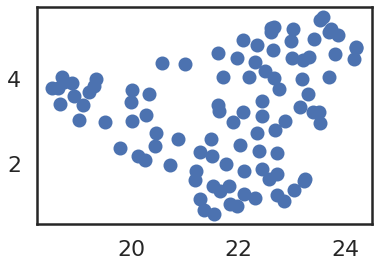

In [83]:
plt.scatter(x=lu[:,0], y=lu[:,1])

In [84]:
%%time
su = fit.fit_transform(short_latents.cpu().detach().numpy()) 

CPU times: user 2min 58s, sys: 133 ms, total: 2min 58s
Wall time: 7.87 s


In [85]:
su.shape

(100, 2)

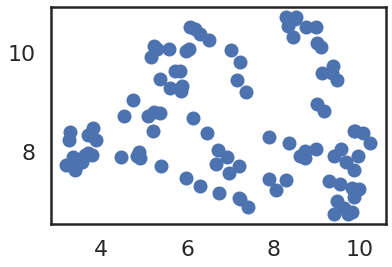

In [86]:
plt.scatter(x=su[:,0], y=su[:,1])